<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Лемматизация" data-toc-modified-id="Лемматизация-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Лемматизация</a></span></li><li><span><a href="#Баланс-классов" data-toc-modified-id="Баланс-классов-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Баланс классов</a></span></li><li><span><a href="#Векторизация-тескта" data-toc-modified-id="Векторизация-тескта-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Векторизация тескта</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Подбор-гиперпараметров" data-toc-modified-id="Подбор-гиперпараметров-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Подбор гиперпараметров</a></span></li><li><span><a href="#Проверка-модели-на-тестовой-выборке" data-toc-modified-id="Проверка-модели-на-тестовой-выборке-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Проверка модели на тестовой выборке</a></span></li></ul></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li></ul></div>

# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

In [54]:
%autosave 60

Autosaving every 60 seconds


In [55]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.utils import shuffle
import numpy as np

from tqdm import tqdm

import re 

from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error, make_scorer, classification_report, accuracy_score, confusion_matrix, roc_auc_score, roc_curve, recall_score, precision_score,f1_score, mean_squared_error
from sklearn.model_selection import train_test_split,  TimeSeriesSplit, cross_val_predict,cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression

import nltk
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords as nltk_stopwords
from sklearn.feature_extraction.text import TfidfVectorizer

import warnings
warnings.filterwarnings('ignore')

In [56]:
def explore_data(df):
    display(
        "Сводная информация:", df.info(),
        "10 строк:", df.head(10),
        "Столбцы:", df.columns,
       # "Числовое описание:", df.describe(),
        "Сумма пропусков:", df.isna().sum(),
        "Доля пропусков:", df.isna().mean(),
        "Явные дубликаты:", df.duplicated().sum(),
        #"Корреляция:", df.corr(),
       # sns.heatmap(df.corr())
    )

In [57]:
toxic_comments_df= pd.read_csv('/datasets/toxic_comments.csv')

In [58]:
explore_data(toxic_comments_df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159571 non-null  object
 1   toxic   159571 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


'Сводная информация:'

None

'10 строк:'

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0
5,"""\n\nCongratulations from me as well, use the ...",0
6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1
7,Your vandalism to the Matt Shirvington article...,0
8,Sorry if the word 'nonsense' was offensive to ...,0
9,alignment on this subject and which are contra...,0


'Столбцы:'

Index(['text', 'toxic'], dtype='object')

'Сумма пропусков:'

text     0
toxic    0
dtype: int64

'Доля пропусков:'

text     0.0
toxic    0.0
dtype: float64

'Явные дубликаты:'

0

### Лемматизация

In [59]:
wnl = WordNetLemmatizer()
def clear_text(text):
    #m = Mystem()
    lemm_list = wnl.lemmatize(text)
    lemm_text = "".join(lemm_list)
    clear_lemm_text = re.sub(r'[^a-zA-Z]', ' ', lemm_text)    
    return " ".join(clear_lemm_text.split())


In [60]:

nltk.download('averaged_perceptron_tagger')
from nltk.corpus import wordnet

def pos_tagger(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:         
        return None

def lemmatize_text(text):
    clear_text = " ".join(re.sub(r'[^a-zA-Z]', ' ', text).split())
    pos_tagged = nltk.pos_tag(nltk.word_tokenize(clear_text))
    wordnet_tagged = list(map(lambda x: (x[0], pos_tagger(x[1])), pos_tagged))

    lemmatized_sentence = []
    for word, tag in wordnet_tagged:
        if tag is None:
            lemmatized_sentence.append(word)
        else:       
            lemmatized_sentence.append(wnl.lemmatize(word, tag))
    return " ".join(lemmatized_sentence)

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


Проверка лемматизации

In [61]:
sentence = 'the cat is sitting with the bats on the striped mat under many badly flying geese' 
lemmatize_text(sentence)

'the cat be sit with the bat on the striped mat under many badly fly geese'

In [64]:
%%time
toxic_comments_df['clear_text'] = toxic_comments_df['text'].apply(lemmatize_text)
#toxic_comments_df['text'].head().apply(lemmatize_text)

CPU times: user 9min 2s, sys: 6.47 s, total: 9min 9s
Wall time: 9min 9s


In [65]:
toxic_comments_df.head()

,text,toxic,clear_text
0,Explanation\nWhy the edits made under my usern...,0,Explanation Why the edits make under my userna...
1,D'aww! He matches this background colour I'm s...,0,D aww He match this background colour I m seem...
2,"Hey man, I'm really not trying to edit war. It...",0,Hey man I m really not try to edit war It s ju...
3,"""\nMore\nI can't make any real suggestions on ...",0,More I can t make any real suggestion on impro...
4,"You, sir, are my hero. Any chance you remember...",0,You sir be my hero Any chance you remember wha...


### Баланс классов

In [70]:
features = toxic_comments_df['clear_text']
target = toxic_comments_df['toxic']

In [71]:
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.25, random_state=12345, stratify = target)

<AxesSubplot:title={'center':'Распределение классов до разделения набора'}>

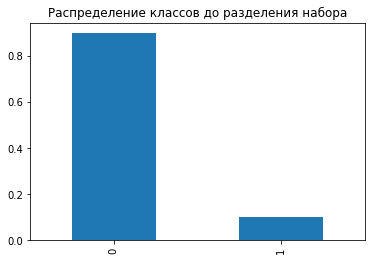

In [72]:
target.value_counts(normalize=True).plot(kind='bar', title='Распределение классов до разделения набора')

<AxesSubplot:title={'center':'Распределение классов после разделения набора'}>

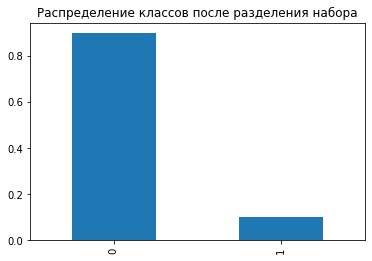

In [73]:
target_train.value_counts(normalize=True).plot(kind='bar', title='Распределение классов после разделения набора')

Соотношение классов до и после разделения на тестовую и тренировочную выборку сохранилось. Очевидно Превосходство 0 класса 


def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled



features_downsampled, target_downsampled = downsample(features_train, target_train, 0.1)

target_downsampled.value_counts(normalize=True).plot(kind='bar', title='Распределение классов после балансировки')

### Векторизация тескта

In [74]:
corpus = features_train.values
print(corpus[0])

Belarus a developed country Hahaha nothing more to say


In [75]:
nltk.download('stopwords')
stopwords = set(nltk_stopwords.words('english'))
count_tf_idf = TfidfVectorizer(stop_words=stopwords)
features_train = count_tf_idf.fit_transform(corpus)
features_test = count_tf_idf.transform(features_test)

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [76]:
print(features_train.shape)
print(features_test.shape)

(119678, 142100)
(39893, 142100)


### Вывод
 * Произведена подготовка для обучения моделей. 
 * После ознакомления с набором объявлен корпус текстов. Затем тексты были очищены и лемматизированы. 
 * Проверка соотношения классов показала, что в датасете имеет место явный дисбаланс. 
 * Для векторизации текстов был использован TfidfVectorizer(). После векторизации датасет образовал матрицу размером 
 * датасет разделен на обучающую и тестовые выборки 


## Обучение

In [39]:
def best_hypers_for_model(model, hyperparams, scorer):
    
    #ts_cv = TimeSeriesSplit(n_splits=8).split(features_train)
    clf = GridSearchCV(model, hyperparams, scoring=scorer, cv=3)
    clf.fit(features_train, target_train)
    print(str(model)[:-2],"Best parameters set found on development set:\n")
    print(clf.best_params_)
    print("\nGrid scores on development set:\n")
    for mean, std, params in zip(clf.cv_results_['mean_test_score'], clf.cv_results_['std_test_score'], clf.cv_results_['params']):
        print("%0.6f for %r"% (abs(mean), params))

<div class="alert alert-success">
<h2> Полезно запомнить <a class="tocSkip"></h2>

Кросс-валидацию вместе с undersampling / oversampling использовать нельзя - они меняют распределение набора и у тебя получаются искаженные метрики, следовательно, и параметры, которые будут подобраны не совсем оптимальны.

In [40]:
def best_model_result(model_dict):
    
    predictions_dict = {}
    for model_name in tqdm(model_dict):
        l_start = time.time()
        model = model_dict[model_name]
        model.fit(features_train, target_train)
        l_end = time.time()
        result.loc[model_name, "learning_time"] = l_end - l_start
        p_start = time.time()
        predictions = model.predict(features_test)
        predictions_dict[model_name] = predictions
        p_end = time.time()
        result.loc[model_name, "predict_time"] = p_end - p_start
        result.loc[model_name, "f1"] = f1_score(predictions, target_test)
    return predictions_dict

### Подбор гиперпараметров

In [77]:
%%time
MODEL_SETTINGS = {'class_weight': ['balanced'],
                  'fit_intercept': [True], 
                 'solver':['liblinear'],
                  'C': [0.1, 1, 10],
                  'random_state':[12345]}
best_hypers_for_model(LogisticRegression(),MODEL_SETTINGS,'f1')

LogisticRegression Best parameters set found on development set:

{'C': 10, 'class_weight': 'balanced', 'fit_intercept': True, 'random_state': 12345, 'solver': 'liblinear'}

Grid scores on development set:

0.703971 for {'C': 0.1, 'class_weight': 'balanced', 'fit_intercept': True, 'random_state': 12345, 'solver': 'liblinear'}
0.747678 for {'C': 1, 'class_weight': 'balanced', 'fit_intercept': True, 'random_state': 12345, 'solver': 'liblinear'}
0.767195 for {'C': 10, 'class_weight': 'balanced', 'fit_intercept': True, 'random_state': 12345, 'solver': 'liblinear'}
CPU times: user 59.9 s, sys: 1min 6s, total: 2min 6s
Wall time: 2min 6s


In [78]:
%%time
MODEL_SETTINGS = {'class_weight': ['balanced'],
            'max_depth':[x for x in range(2, 152,10)],
                  'random_state':[12345]}
best_hypers_for_model(DecisionTreeClassifier(),MODEL_SETTINGS,'f1')

DecisionTreeClassifier Best parameters set found on development set:

{'class_weight': 'balanced', 'max_depth': 142, 'random_state': 12345}

Grid scores on development set:

0.371563 for {'class_weight': 'balanced', 'max_depth': 2, 'random_state': 12345}
0.566155 for {'class_weight': 'balanced', 'max_depth': 12, 'random_state': 12345}
0.599717 for {'class_weight': 'balanced', 'max_depth': 22, 'random_state': 12345}
0.617555 for {'class_weight': 'balanced', 'max_depth': 32, 'random_state': 12345}
0.625423 for {'class_weight': 'balanced', 'max_depth': 42, 'random_state': 12345}
0.616946 for {'class_weight': 'balanced', 'max_depth': 52, 'random_state': 12345}
0.626737 for {'class_weight': 'balanced', 'max_depth': 62, 'random_state': 12345}
0.632329 for {'class_weight': 'balanced', 'max_depth': 72, 'random_state': 12345}
0.636391 for {'class_weight': 'balanced', 'max_depth': 82, 'random_state': 12345}
0.641015 for {'class_weight': 'balanced', 'max_depth': 92, 'random_state': 12345}
0.64079

In [37]:
%%time
#'max_depth':[x for x in range(2, 152,10)], 'n_estimators': [x for x in range (10, 51, 10)],
MODEL_SETTINGS = {'class_weight': ['balanced'],
                  'n_estimators': [x for x in range (10, 51, 10)],
                  'random_state':[12345]}
best_hypers_for_model(RandomForestClassifier(),MODEL_SETTINGS,'f1')


RandomForestClassifier Best parameters set found on development set:

{'class_weight': 'balanced', 'n_estimators': 50, 'random_state': 12345}

Grid scores on development set:

0.640756 for {'class_weight': 'balanced', 'n_estimators': 10, 'random_state': 12345}
0.652071 for {'class_weight': 'balanced', 'n_estimators': 20, 'random_state': 12345}
0.657040 for {'class_weight': 'balanced', 'n_estimators': 30, 'random_state': 12345}
0.662989 for {'class_weight': 'balanced', 'n_estimators': 40, 'random_state': 12345}
0.665719 for {'class_weight': 'balanced', 'n_estimators': 50, 'random_state': 12345}
CPU times: user 15min 22s, sys: 2.86 s, total: 15min 25s
Wall time: 15min 26s


In [ ]:
MODEL_SETTINGS = {
    'max_depth': [x for x in range (2, 21,2)],
  'learning_rate': [0.1, 0.5, 0.8],
  'n_estimators': [x for x in range (10, 51, 10)]
  }
#'max_depth': [x for x in range (2, 152,10)]                
best_hypers_for_model(GradientBoostingClassifier(),MODEL_SETTINGS,'f1')

In [ ]:
MODEL_SETTINGS = {
  'verbose':[False],
  'learning_rate': [0.1, 0.5, 0.8],
  'iterations': [2,3,5],
  'max_depth': [x for x in range (2, 21,2)]}
#'max_depth': [x for x in range (2, 152,10)]
best_hypers_for_model(CatBoostClassifier(),MODEL_SETTINGS,'f1')

Из всех выбранных моделей наилучший результат показала LogisticRegression

<div class="alert alert-success">
    <h2> Полезно запомнить <a class="tocSkip"> </h2>

<b>Некоторые замечания и рекомендации💡:</b>

   
    
CatBoost поддерживает работу с текстом "из коробки" , но он работает только с GPU. пример и сравнение с BERT для похожей задачи.
        
https://towardsdatascience.com/unconventional-sentiment-analysis-bert-vs-catboost-90645f2437a9

Тут очень классный ноутбук

https://github.com/catboost/tutorials/blob/master/text_features/text_features_in_catboost.ipynb

### Проверка модели на тестовой выборке

In [83]:
result = pd.DataFrame(columns=["f1", "learning_time", "predict_time"])

In [84]:
predictions = best_model_result({'LogisticRegression': LogisticRegression(C=10, class_weight='balanced',
                                fit_intercept=True, random_state=12345, solver='liblinear')})


100%|██████████| 1/1 [00:25<00:00, 25.36s/it]


In [85]:
result

,f1,learning_time,predict_time
LogisticRegression,0.776968,25.271108,0.065887


## Выводы

Таким образом, наиболее оптимальной моделью оказалась LogisticRegression(C=10, class_weight='balanced',fit_intercept=True, random_state=12345, solver='liblinear') с результатом на тестовой выборке f1=0.777.

Для достижения целевого показателя метрики при векторизации текста пришлось отказаться от параметра min_df, что значительно увеличило размер выборки и время обучения моделей. Для Catboost и gradientboosting подобрать оптимальные гиперпараметры  не удалось- занимает слишком много времени(как вариант решения проблемы можно попробовать отказаться от кроссвалидации при подборе гиперпараметров). 


